# Targetted analysis for PD progression

Created 10/03/2018    
By Hirotaka Iwaki

### Predictors
1. Variants in interest including 92 risk variants in the most recent meta-analysis, 
2. Genetic risk score composed of 92 risk variants.

### Outcomes

1. Binomial Outcomes:    
constipation(CONST), cognitive impairment (DEMENTIA), depressive mood (DEPR), dyskinesia (DYSKINESIAS), Hoehn Yahr Scale 3 or more (HY3), hyposmia (HYPOSMIA), insomnia (INS), motor fluctuations (MOTORFLUX), REM sleep behavior disorder (RBD), restless legs syndrome (RL), Modified Schwab and England Activities of Daily Living Scale 70 or less (SEADL70), daytime sleepiness (SLEEP)    

2. Contious Outcomes:    
Hoehn and Yahr scale (HY), MMSE, MoCA, SEADL, UPDRS_1/2/3/4/total    

### Analysis
For binomial outcomes;
1. **(lgsbl)** logistic regression analysis at baseline: logitsic regression
2. **(coxhm)** survival analysis for those who didn't have the symptom at the baseline: cox model with varying covariates.

For continous outcomes;
1. slope-analysis
    * **(lnmxs)** Linear model with random intercept and random slope. 
2. intercept analysis
    * **(lnmxi)** linear model with random intercept for repaeated obs.    
        (linear model for the cohort with single obs -> **lnsgl**)
    
### Covariates
1. Sex (FEMALE)
2. Years of Education (YEARSEDUC)
3. Family History (FAMILY_HISTORY)
4. Age at diagnosis (AAO)
5. Years from diagnosis at baseline for cox model (BLDfDIAG) / Years from diagnosis for glmm model (YEARfDIAG)
6. Treatment status (DOPA, AGNOIST)
7. Population structure (PC1-5)

### Meta-analysis
Fixed model

# 1. Prepare predictors

In [5]:
%%bash
# Predictors (Variants in interest)
rm -f predictor/list.txt
awk -F, 'NR>1{print $4":"$5,$2,$1}' data/ProgressionPlus.csv >> predictor/list.txt
awk 'NR>1{print $1,$48,$34}' data/Meta5.tab |  sed 's/chr//g' >> predictor/list.txt
LANG=C sort predictor/list.txt | sed '1 iPOS ID NearGenpoe' | sed 's/ /\t/g' | uniq -w 15 > predictor/info.txt
awk '{print $1,toupper($26),$29}' data/Meta5.tab | sed 's/chr//g'  > predictor/Meta5score.txt
# GBA score (0 for a mutation none carrier, 1 for otherwise)
echo '1:155205634 C 1
1:155206037 A 10
1:155206167 T 100' > predictor/gba.txt

In [88]:
%%bash
# create the data with rows as individuals and columns as dosage. (R>0.3)
## Columns CHR:POS_A2_A1
rm -rf t/t # Erase working folder
mkdir -p t/t # Create working folder
INPUT="/data/LNG/CORNELIS_TEMP/progression_GWAS"
LIST=predictor/list.txt
rm  -f t/swarm_DoseConv*
for DATASET in $(ls ../dataset) ;do
#     mkdir -p dataset/$DATASET/target
    OUT=../dataset/$DATASET/target
    mkdir -p $OUT
    for CHR in $(cat $LIST | cut -d':' -f1 | sort -n| uniq);do # chromosomes in the list
    echo "\
grep ^$CHR: $LIST | cut -d' ' -f1 | sed 's/$/\t/'> t/t/$DATASET.$CHR.pos.txt; \
zgrep -f t/t/$DATASET.$CHR.pos.txt $INPUT/$DATASET/chr"$CHR".info.gz | cut -f1-8 > t/t/$DATASET.$CHR.info.txt; \
awk '\$7>0.3{print}' t/t/$DATASET.$CHR.info.txt | cut -f1 | sed 's/:/\t/' | \
 awk 'BEGIN{OFS=\"\t\"}{print \$1,\$2,\$2}' > t/t/$DATASET.$CHR.txt; \
bcftools view -R t/t/$DATASET.$CHR.txt $INPUT/$DATASET/chr"$CHR".dose.vcf.gz | bgzip -c > t/t/$DATASET.$CHR.vcf.gz; \
DosageConvertor --vcfDose t/t/$DATASET.$CHR.vcf.gz --type mach --format 1 --prefix t/t/$DATASET.$CHR.filter; \
cat t/t/$DATASET.$CHR.filter.mach.info | cut -f 1,2,3 | sed 's/\t/_/g' | \
 sed '1 cFID\nIID\nDOSE' | paste -s | sed 's/ /\t/g'> t/t/$DATASET.$CHR.header.txt; \
zless t/t/$DATASET.$CHR.header.txt t/t/$DATASET.$CHR.filter.mach.dose.gz | sed 's/->/\t/g' | cut -f2- > $OUT/$CHR.txt; \
echo \"$DATASET $CHR\" >> t/swarm_DoseConv_log.txt; \\" >> t/swarm_DoseConv.txt
    done # Then get the info file
    echo "\
cat t/t/$DATASET.*.info.txt | sed '1 iPOS:LOC\tA2\tA1\tALT_Frq\tMAF\tAvgCall\tRsq\tGenotyped' > $OUT/all.info" >> t/swarm_DoseConv.txt
done
swarm -f t/swarm_DoseConv.txt -g 1 -p 2 -b 4 --time=0:15:00 --module samtools,dosageconvertor --logdir t/swarm --partition=quick --devel

Loading modules samtools dosageconvertor
13 commands run in 2 subjobs, each command requiring 1 gb and 1 thread, packing 2 processes per subjob, running 4 processes serially per subjob
sbatch --array=0-1 --job-name=swarm --output=/dev/null --error=/dev/null --cpus-per-task=2 --mem=2048 --partition=quick --time=60:00 /spin1/swarm/iwakih2/tcK2L8g0CW/swarm.batch


In [89]:
%%bash
swarm -f t/swarm_DoseConv.txt -g 1 -p 2 -b 4 --time=0:15:00 --module samtools,dosageconvertor --logdir t/swarm --partition=quick

10740634


In [72]:
%%bash
# create the data with rows as individuals and columns as score. (based on R>0.8 and integer call)
rm -rf t/t t/swarm # Erase working folder
mkdir -p t/t  # Create working folder
INPUT="/data/LNG/CORNELIS_TEMP/progression_GWAS"
LIST=predictor/list.txt
rm  -f t/swarm_grs*

# Normalization of the output GRS
echo '
args <- commandArgs(trailingOnly = TRUE)
INFILE = args[1]
OUTNAME = args[2]
df1 = read.csv(INFILE)
mean=mean(df1$SCORE)
sd=sd(df1$SCORE)
df1$SCORE=(df1$SCORE-mean)/sd
write.table(df1, OUTNAME, row.names = F, quote = F, sep = "\t")
' > t/scoreNormalization.R

# Get grsZ 
for DATASET in $(ls ../dataset/);do
    echo "\
plink --bfile $INPUT/$DATASET/plink_files_hard/$DATASET.HARDCALLS \
    --score predictor/Meta5score.txt 1 2 3 header --out t/t/"$DATASET"; \
awk 'BEGIN{OFS=\",\"}{print \$2,\$6}' t/t/"$DATASET".profile > t/t/"$DATASET".txt; \
Rscript --vanilla t/scoreNormalization.R t/t/"$DATASET".txt t/t/"$DATASET"_META5.txt; \
sed 's/SCORE/META5_N_A/' t/t/"$DATASET"_META5.txt > ../dataset/$DATASET/target/score_META5.txt; \
plink --bfile $INPUT/$DATASET/plink_files_hard/$DATASET.HARDCALLS \
    --score predictor/gba.txt 1 2 3 sum --out t/t/"$DATASET"_2; \
awk 'BEGIN{OFS=\"\t\"}{print \$2,\$6}' t/t/"$DATASET"_2.profile | sed 's/SCORESUM/GBA_N_A/' > ../dataset/$DATASET/target/score_GBA.txt
" >> t/swarm_grs.txt
done

swarm -f t/swarm_grs.txt -g 4 -p 2 -b 4 --time=0:10:00 --module R,plink --logdir t/swarm --partition=quick --devel

Loading modules R plink
13 commands run in 2 subjobs, each command requiring 4 gb and 1 thread, packing 2 processes per subjob, running 4 processes serially per subjob
sbatch --array=0-1 --job-name=swarm --output=/dev/null --error=/dev/null --cpus-per-task=2 --mem=8192 --partition=quick --time=40:00 /spin1/swarm/iwakih2/tH6x4CDCON/swarm.batch


rm: cannot remove 't/t': Directory not empty


In [95]:
%%bash
# Quick check for uncalculated SNPs
rm t/GRSnopred.txt
head -n1000 t/t/*nopred >> t/GRSnopred.txt
awk '/_2.nopred/{print NR,$0}' t/GRSnopred.txt 
echo '
1 example'
tail -n +30 t/GRSnopred.txt | head -n2

30 ==> t/t/DIGPD_chip_2.nopred <==

1 example
==> t/t/DIGPD_chip_2.nopred <==
NOSNP	1:155205634


In [90]:
%%bash
# Can be done in 30 sec
rm -rf t/swarm_target_summ.txt t/swarm ../dataset/*/target/all.txt
echo '
args <- commandArgs(trailingOnly = TRUE)
INFILE = args[1]
OUTPUTs = list.files(INFILE, full.names = T)[grep(".txt", list.files(INFILE))]
for (OUTPUT in OUTPUTs){
  if(OUTPUT==OUTPUTs[1]){data = read.table(OUTPUT, header = T, stringsAsFactors = T)}else{
    data = merge(data, read.table(OUTPUT, header = T, stringsAsFactors = T), by = "IID")
  }
  if(length(grep("DOSE", names(data)))>0){data=data[,-grep("DOSE", names(data))]}
}
write.table(data, paste(INFILE, "all.txt", sep="/"), sep ="\t", quote=F, row.names=F)' > t/target_summ.R
for DATASET in $(ls ../dataset);do
    Rscript --vanilla t/target_summ.R "../dataset/$DATASET/target"
done

Predictors are ready.    
Outcomes are also ready from the GWAS analysis

# 2. Analysis Phase

In [14]:
%%bash
# Create output folders
FOLDER=outT
mkdir -p $FOLDER
cd $FOLDER
for DATASET in $(ls ../../dataset/);do
    mkdir -p $DATASET
    cd $DATASET
    mkdir -p lgsbl
    mkdir -p coxhm
    mkdir -p lnmxs
    mkdir -p lnmxi
    mkdir -p lnsgl
    cd ..
done

In [25]:
%%bash
## cross-sectional analysis
# lgsbl
echo '
args <- commandArgs(trailingOnly = TRUE)
# Variables
KEY=strsplit(args[1], ";")[[1]]
ANALYSIS=KEY[1]
DATASET=KEY[2]
OUTCOME=KEY[3]
COVs   =KEY[4]
COVPC  =paste(gsub(",", "+", COVs), "+PC1+PC2+PC3+PC4+PC5", sep="")
INFILE  = args[2]
OUT = args[3]
library(data.table);library(dplyr)
## Read genptypes
SNPset = fread(INFILE)
SNPs = names(SNPset)[-1] # 1 SNP name starts from col 3
SNPset$GBA_N_A=ifelse(SNPset$GBA_N_A>0, 1, 0) # recode
# Read phenotype
cohort=fread(paste("pheno/", ANALYSIS, "/", DATASET, ".txt", sep = "")) %>%
  inner_join(., fread(paste("pheno/", ANALYSIS, "/", DATASET, "_cov.txt", sep = "")), by = c("FID", "IID")) %>% 
  select(c("IID", OUTCOME, strsplit(COVPC, "\\+")[[1]])) %>% filter(complete.cases(.)) %>% filter(.[, OUTCOME]>0
)
# rescaling
cohort[,(strsplit(COVPC, "\\+")[[1]])] = as.data.frame(scale(cohort[,(strsplit(COVPC, "\\+")[[1]])]))
## Merge data
cohort_snp = left_join(cohort, SNPset, by = "IID")
# ANALYSIS
test.listfunc = function(x){
  MODEL = paste("I(",OUTCOME, "==2)", "~`", SNPs[x], "`+", COVPC, sep = "")
  testlgs = try(glm(eval(parse(text = MODEL)), data = cohort_snp, family = binomial()),silent = T)
  if(class(testlgs)[1]=="try-error"){
    sumstat=c(SNPs[x], "NoConverge", rep(NA,4))
  }else{
    temp= summary(testlgs)$coefficients
    row = grep(substr(SNPs[x],1,7), rownames(temp))
    if(row %>% length == 0){ # In this case, SNP is dropeed from the model
      sumstat=c(SNPs[x], "NoVforSNP", rep(NA, 4))
    }else{
      RES = temp[row,]
      EVENT_OBS = paste(sum(cohort_snp[, OUTCOME]==2), nrow(cohort_snp), sep="_")
      sumstat <- c(SNPs[x], EVENT_OBS, RES[3], RES[1], RES[2], RES[4])
    }
  }
  return(sumstat)
}
temp = lapply(1:length(SNPs), test.listfunc)
temp2 = do.call(rbind, temp) %>% data.frame%>%filter(complete.cases(.))
names(temp2)=c("POS_A2_A1", "EVENT_OBS", "Tvalue", "BETA", "SE", "P")
NEWDIR = paste(OUT, DATASET, ANALYSIS, OUTCOME, sep = "/")
dir.create(NEWDIR, recursive = T, showWarnings = F)
FILENAME = strsplit(INFILE, "/")[[1]][5] %>% substr(.,1,nchar(.))
write.table(temp2, paste(NEWDIR, FILENAME, sep="/"), row.names = F, quote = F, sep = "\t")
line=paste("Rscript --vanilla t/", ANALYSIS, ".R \"", paste(args, collapse = "\" \""), "\"", sep="")
write(line,file=paste("finish_", ANALYSIS, ".txt", sep=""),append=TRUE)' > t/lgsbl.R

# lnsgl
echo '
args <- commandArgs(trailingOnly = TRUE)
# Variables
KEY=strsplit(args[1], ";")[[1]]
ANALYSIS=KEY[1]
DATASET=KEY[2]
OUTCOME=KEY[3]
COVs   =KEY[4]
COVPC  =paste(gsub(",", "+", COVs), "+PC1+PC2+PC3+PC4+PC5", sep="")
INFILE  = args[2]
OUT = args[3]
library(data.table);library(dplyr)
## Read genptypes
SNPset = fread(INFILE)
SNPs = names(SNPset)[-1] # 1 SNP name starts from col 3
SNPset$GBA_N_A=ifelse(SNPset$GBA_N_A>0, 1, 0) # recode
# Read phenotype
cohort=fread(paste("pheno/", ANALYSIS, "/", DATASET, ".txt", sep = "")) %>%
  inner_join(., fread(paste("pheno/", ANALYSIS, "/", DATASET, "_cov.txt", sep = "")), by = c("FID", "IID")) %>% 
  select(c("IID", OUTCOME, strsplit(COVPC, "\\+")[[1]])) %>% filter(complete.cases(.))
# rescaling
cohort[,(strsplit(COVPC, "\\+")[[1]])] = as.data.frame(scale(cohort[,(strsplit(COVPC, "\\+")[[1]])]))
## Merge data
cohort_snp = left_join(cohort, SNPset, by = "IID")
# ANALYSIS
test.listfunc = function(x){
  MODEL = paste(OUTCOME, "~`", SNPs[x], "`+", COVPC, sep = "")
  testlgs = try(lm(eval(parse(text = MODEL)), data = cohort_snp),silent = T)
  if(class(testlgs)[1]=="try-error"){
    sumstat=c(SNPs[x], "NoConverge", rep(NA,4))
  }else{
    temp= summary(testlgs)$coefficients
    row = grep(substr(SNPs[x],1,7), rownames(temp))
    if(row %>% length == 0){ # In this case, SNP is dropeed from the model
      sumstat=c(SNPs[x], "NoVforSNP", rep(NA, 4))
    }else{
      RES = temp[row,]
      EVENT_OBS = paste(nrow(cohort_snp), nrow(cohort_snp), sep="_")
      sumstat <- c(SNPs[x], EVENT_OBS, RES[3], RES[1], RES[2], RES[4])
    }
  }
  return(sumstat)
}
temp = lapply(1:length(SNPs), test.listfunc)
temp2 = do.call(rbind, temp) %>% data.frame%>%filter(complete.cases(.))
names(temp2)=c("POS_A2_A1", "EVENT_OBS", "Tvalue", "BETA", "SE", "P")
NEWDIR = paste(OUT, DATASET, ANALYSIS, OUTCOME, sep = "/")
dir.create(NEWDIR, recursive = T, showWarnings = F)
FILENAME = strsplit(INFILE, "/")[[1]][5] %>% substr(.,1,nchar(.))
write.table(temp2, paste(NEWDIR, FILENAME, sep="/"), row.names = F, quote = F, sep = "\t")
line=paste("Rscript --vanilla t/", ANALYSIS, ".R \"", paste(args, collapse = "\" \""), "\"", sep="")
write(line,file=paste("finish_", ANALYSIS, ".txt", sep=""),append=TRUE)' > t/lnsgl.R


# Cohort level longitudinal analysis with R (coxhm, lnmxs and lnmxi)

## coxhm 
# args=c("coxhm;CORIELL;DEMENTIA;FEMALE,YEARSEDUC,FAMILY_HISTORY,AAO,BLDfDIAG,DOPA,AGONIST", "../dataset/CORIELL/maf01rsq3_20Kcut/cut22.2.txt.gz", "outGWAS")
echo '
args <- commandArgs(trailingOnly = TRUE)
# Variables
KEY=strsplit(args[1], ";")[[1]]
ANALYSIS=KEY[1]
DATASET=KEY[2]
OUTCOME=KEY[3]
COVs   =KEY[4]
COVPC  =paste(gsub(",", "+", COVs), "+PC1+PC2+PC3+PC4+PC5", sep="")
INFILE  = args[2]
OUT = args[3]
library(data.table);library(dplyr)
## Read genptypes
SNPset = fread(INFILE)
SNPs = names(SNPset)[-c(1:2)] # 1 IID, DOSE SNP name starts from col 3
# Read phenotypes
cohort=fread(paste("pheno/", ANALYSIS, "/", OUTCOME, "_", DATASET, ".txt", sep = "")) %>% arrange(IID, TSTART) %>%
  select(c("IID", "TSTART", "TSTOP", OUTCOME, strsplit(COVPC, "\\+")[[1]])) %>% filter(complete.cases(.))
# rescaling
cohort[,(strsplit(COVPC, "\\+")[[1]])] = as.data.frame(scale(cohort[,(strsplit(COVPC, "\\+")[[1]])]))
## Merge data
cohort_snp = left_join(cohort, SNPset, by = "IID")
# ANALYSIS
library(survival)
cohort_snp$SurvObj1 = with(cohort_snp, Surv(TSTART, TSTOP, OUTCOME == 1))
test.listfunc = function(x){
  MODEL = paste("SurvObj1 ~", "`", SNPs[x], "`+", COVPC, sep = "")
  testCox = try(coxph(eval(parse(text = MODEL)), data = cohort_snp),silent = T)
  if(class(testCox)[1]=="try-error"){
    sumstat=c(SNPs[x], "NoConverge", rep(NA,4))
  }else{
    temp= summary(testCox)$coefficients
    if(grep(substr(SNPs[x],1,7), rownames(temp)) %>% length == 0){ # In this case, SNP is dropeed from the model
      sumstat=c(SNPs[x], "NoVforSNP", rep(NA, 4))
    }else{
      RES = temp[1,]
      EVENT_OBS = paste(testCox$nevent, testCox$n, sep="_")
      sumstat <- c(SNPs[x], EVENT_OBS, as.numeric(RES[4]), RES[1], RES[3], RES[5])
    }
  }
  return(sumstat)
}
temp = lapply(1:length(SNPs), test.listfunc)
temp2 = do.call(rbind, temp) %>% data.frame%>%filter(complete.cases(.))
names(temp2)=c("POS_A2_A1", "EVENT_OBS", "Tvalue", "BETA", "SE", "P")
NEWDIR = paste(OUT, DATASET, ANALYSIS, OUTCOME, sep = "/")
dir.create(NEWDIR, recursive = T, showWarnings = F)
FILENAME = strsplit(INFILE, "/")[[1]][5] %>% substr(.,1,nchar(.))
write.table(temp2, paste(NEWDIR, FILENAME, sep="/"), row.names = F, quote = F, sep = "\t")
line=paste("Rscript --vanilla t/", ANALYSIS, ".R \"", paste(args, collapse = "\" \""), "\"", sep="")
write(line,file=paste("finish_", ANALYSIS, ".txt", sep=""),append=TRUE)
' > t/coxhm.R

# lnmxi
# args=c("lnmxi;CORIELL;SEADL;FEMALE,YEARSEDUC,FAMILY_HISTORY,AAO,YEARfDIAG,DOPA,AGONIST", "../dataset/CORIELL/maf01rsq3_20Kcut/cut22.2.txt.gz", "outGWAS")
echo '
# Read phenotype
library(lme4)
cohort=fread(paste("pheno/", ANALYSIS, "/", DATASET, ".txt", sep = "")) %>% arrange(IID, YEARfDIAG) %>% 
  select(c("IID", OUTCOME, strsplit(COVPC, "\\+")[[1]])) %>% filter(complete.cases(.))
# rescaling
cohort[,(strsplit(COVPC, "\\+")[[1]])] = as.data.frame(scale(cohort[,(strsplit(COVPC, "\\+")[[1]])]))
# Merge data
cohort_snp = left_join(cohort, SNPset, by = "IID")
# ANALYSIS
test.listfunc = function(x){
  # Models
  MODEL = paste(OUTCOME, "~", "`", SNPs[x], "`+", paste(COVPC, collapse="+"), "+(1|IID)", sep = "")
  testLmer = try(lmer(eval(parse(text = MODEL)), data = cohort_snp),silent = T)
  if(class(testLmer)[1]=="try-error"){
    sumstat=c(SNPs[x], "NoConverge", rep(NA,4))
  }else{
    temp = summary(testLmer)
    temp1 = temp$coefficients
    if(grep(substr(SNPs[x],1,7), rownames(temp1)) %>% length == 0){ # In this case, SNP is dropeed from the model
      sumstat=c(SNPs[x], "Dropped", rep(NA,4))
    }else{
      RES = temp1[2,] # The first row is intercept
      PV_APPROX = 2 * pnorm(-abs(RES[3])) # df is enough large for approximation
      OBS_N = paste(length(temp$residuals), "_", temp$ngrps, sep="")
      sumstat <- c(SNPs[x], OBS_N, RES[3], RES[1], RES[2], PV_APPROX)
    }
  }
  return(sumstat)
}' > t/model_body.txt
sed -n 1,15p t/coxhm.R > t/model_head.txt
sed -n 43,49p t/coxhm.R > t/model_tail.txt
cat t/model_head.txt t/model_body.txt t/model_tail.txt > t/lnmxi.R

# lnmxs  using robust variance. 
# args=c("lnmxs;CORIELL;UPDRS4_scaled;FEMALE,YEARSEDUC,FAMILY_HISTORY,AAO,YEARfDIAG,DOPA,AGONIST", "../dataset/CORIELL/maf01rsq3_20Kcut/cut22.2.txt.gz", "outGWAS")
echo '
# Read phenotype
library(gee)
cohort=fread(paste("pheno/", ANALYSIS, "/", DATASET, ".txt", sep = "")) %>% arrange(IID, YEARfDIAG) %>% 
  select(c("IID", OUTCOME, strsplit(COVPC, "\\+")[[1]])) %>% filter(complete.cases(.))
# rescaling
cohort[,(strsplit(COVPC, "\\+")[[1]])] = as.data.frame(scale(cohort[,(strsplit(COVPC, "\\+")[[1]])]))
# Merge data
cohort_snp = left_join(cohort, SNPset, by = "IID") %>% mutate(IID = as.factor(IID)) # Need to convert IID to factors for gee.
# ANALYSIS
test.listfunc = function(x){
  # Models
  MODEL = paste(OUTCOME, "~", "`", SNPs[x], "`+ `", SNPs[x], "`*YEARfDIAG + ", paste(COVPC, collapse="+"), sep = "")
  testLmer = try(gee(eval(parse(text = MODEL)), data = cohort_snp, id = IID, corstr="exchangeable", silent = T),silent = T)
  if(class(testLmer)[1]=="try-error"){
    sumstat=NA
  }else{
    temp = summary(testLmer)
    temp1 = temp$coefficients %>% data.frame %>% .[,c(1,4,5)]
    names(temp1)=c("BETA", "SE", "Tvalue")
    temp1$POS_A2_A1=rownames(temp1)
    sumstat=temp1[grep(substr(SNPs[x],1,7), rownames(temp1)),] %>% filter(BETA>-5 & BETA<5)
    if(nrow(sumstat)==0){
      sumstat=NA
    }else{
      sumstat = sumstat %>% 
        mutate(P= 2 * pnorm(-abs(Tvalue)), 
               OBS_N=paste(length(temp$residuals), "_", temp$ngrps, sep=""),
               POS_A2_A1=gsub("`", "", POS_A2_A1)) %>% 
        select("POS_A2_A1", "OBS_N", "Tvalue", "BETA", "SE", "P")
    }
  }
  return(sumstat)
}
temp = lapply(1:length(SNPs), test.listfunc)
temp2 = do.call(rbind, temp) %>% data.frame %>% filter(complete.cases(.))
if(length(temp2)==0){q("no")}
NEWDIR = paste(OUT, DATASET, ANALYSIS, OUTCOME, sep = "/")
NEWDIR2 = paste(OUT, DATASET, paste(ANALYSIS, "intcp", sep = "_"), OUTCOME, sep = "/")
dir.create(NEWDIR, recursive = T, showWarnings = F)
dir.create(NEWDIR2, recursive = T, showWarnings = F)
FILENAME = strsplit(INFILE, "/")[[1]][5] %>% substr(.,1,nchar(.))
temp2 %>% filter(grepl(":YEARfDIAG", POS_A2_A1)) %>% 
  mutate(POS_A2_A1=sub(":YEARfDIAG", "", POS_A2_A1)) %>%
  write.table(., paste(NEWDIR, FILENAME, sep="/"), row.names = F, quote = F, sep = "\t")
temp2 %>% filter(!grepl(":YEARfDIAG", POS_A2_A1)) %>% 
  write.table(., paste(NEWDIR2, FILENAME, sep="/"), row.names = F, quote = F, sep = "\t")
line=paste("Rscript --vanilla t/", ANALYSIS, ".R \"", paste(args, collapse = "\" \""), "\"", sep="")
write(line,file=paste("finish_", ANALYSIS, ".txt", sep=""),append=TRUE)
' > t/model_body.txt
sed -n 1,15p t/lnmxi.R > t/model_head.txt
cat t/model_head.txt t/model_body.txt > t/lnmxs.R

In [91]:
%%bash
# Create swarm for R analyses
rm -f swarm/target_cohort_level*.txt 
for i in $(tail -n +2 models.txt);do
    MODEL=$(echo $i | cut -d";" -f1)
    DATASET=$(echo $i | cut -d";" -f2)
    INFILE=$(ls ../dataset/$DATASET/target/all.txt)
    echo "Rscript --vanilla t/$MODEL.R \"$i\" \"$INFILE\" \"outT\"" >> swarm/target_cohort_level.txt 
done
grep 'lgsbl\|lnsgl\|coxhm\|lnmxs' swarm/target_cohort_level.txt > swarm/target_cohort_level_seleted.txt 
swarm -f swarm/target_cohort_level_seleted.txt -p 2 -b 27 --time=00:05:00 --module R --logdir t/swarm --partition=quick --devel

Loading modules R
211 commands run in 4 subjobs, each command requiring 1.5 gb and 1 thread, packing 2 processes per subjob, running 27 processes serially per subjob
sbatch --array=0-3 --job-name=swarm --output=/dev/null --error=/dev/null --cpus-per-task=2 --mem=3072 --partition=quick --time=02:15:00 /spin1/swarm/iwakih2/mlQBK0LcAj/swarm.batch


In [92]:
%%bash
rm finish_*
swarm -f swarm/target_cohort_level_seleted.txt -p 2 -b 18 --time=00:05:00 --module R --logdir t/swarm --partition=quick

10741280


In [93]:
%%bash
echo 'If errored, the following will return unfinished line'
cat finish_* swarm/target_cohort_level_seleted.txt |sort |uniq -u

If errored, the following will return unfinished line


In [94]:
%%bash
# populate all the R results into one file (all.tab) and filter the too large beta
rm -f swarm/populate.txt
RESULT="outT"  
for MODEL in coxhm lnmxi lnmxs lgsbl lnsgl;do
    for i in $(grep ^"$MODEL" models.txt);do
        DATASET=$(echo $i | cut -d";" -f2)
        OUTCOME=$(echo $i | cut -d";" -f3)
        if [[ "$OUTCOME" =~ ^(MMSE|MOCA|SEADL)$ ]]; then
            B_THRES=10
        else
            B_THRES=5
        fi
        echo "
cat $RESULT/$DATASET/$MODEL/$OUTCOME/*.txt | sed 's/_/\t/g' | cut -f 1-3,7-9 |\
awk 'BEGIN{OFS=\"\t\"}{print \$1,\$3,\$2,\$4,\$5,\$6}' | awk 'NR==1{print;next} -$B_THRES < \$4 && \$4 < $B_THRES{print|\"LANG=C sort\"}' \
 > $RESULT/$DATASET/$MODEL/$OUTCOME/all.tab" \
>> swarm/populate.txt
    done
done

sed -i 's/lnmxi/lnmxs_intcp/g' swarm/populate.txt # lnmxi -> lnmxs
head -n2 swarm/populate.txt
swarm -f swarm/populate.txt --time=0:01:00 -g 2 -p 2 -b 143 --logdir t/swarm --partition=quick --devel


cat outT/CORIELL/coxhm/DEMENTIA/*.txt | sed 's/_/\t/g' | cut -f 1-3,7-9 |awk 'BEGIN{OFS="\t"}{print $1,$3,$2,$4,$5,$6}' | awk 'NR==1{print;next} -5 < $4 && $4 < 5{print|"LANG=C sort"}'  > outT/CORIELL/coxhm/DEMENTIA/all.tab
285 commands run in 1 subjob, each command requiring 2 gb and 1 thread, packing 2 processes per subjob, running 143 processes serially per subjob
sbatch --array=0-0 --job-name=swarm --output=/dev/null --error=/dev/null --cpus-per-task=2 --mem=4096 --partition=quick --time=02:23:00 /spin1/swarm/iwakih2/d_Q2KV_nEi/swarm.batch


In [95]:
%%bash
swarm -f swarm/populate.txt --time=0:01:00 -g 2 -p 2 -b 111 --logdir t/swarm --partition=quick

10741350


In [96]:
%%bash
## lnsgl -> lnmxs_intcp (only 1 model == lnsgl;PARKFIT;MMSE;FEMALE,AAO,YEARfDIAG)
for i in $(ls outT/*/lnsgl/*/all.tab);do
    NEWDIR=$(echo $i | sed 's/lnsgl/lnmxs_intcp/' | sed 's/\/all.tab//')
    mkdir -p $NEWDIR
    cp $i $NEWDIR
    echo "$i -> $NEWDIR"
done

outT/PARKFIT/lnsgl/MMSE/all.tab -> outT/PARKFIT/lnmxs_intcp/MMSE


In [97]:
%%bash
# MetaAnalysis by METAL.
## First create files ready for meta analysis
# Logistic regression at baseline

for RESULT in "outT";do
    rm -f meta/$RESULT/*/*.metal
    for i in $(tail -n +2 models.txt);do
        MODEL=$(echo $i | cut -d";" -f1)
        DATASET=$(echo $i | cut -d";" -f2)
        OUTCOME=$(echo $i | cut -d";" -f3)
        if [ $MODEL == "lnmxi" ];then # lnsgl will be combined with lnmxi
            MODEL=lnmxs_intcp
        elif [ $MODEL == "lnsgl" ];then # lnsgl will be combined with lnmxi
            MODEL=lnmxs_intcp
        fi
        mkdir -p meta/$RESULT/$MODEL
        echo "
MARKER POS
ALLELE A1 A2
EFFECT BETA
PVALUE P
STDERR SE
PROCESS $RESULT/$DATASET/$MODEL/$OUTCOME/all.tab" >> meta/$RESULT/$MODEL/$OUTCOME.metal
    done
done
for i in $(ls meta/*/*/*.metal);do
    sed -i -e '1 iSCHEME STDERR' \
    -e "\$aOUTFILE $(echo $i | cut -d"." -f1) .tbl\nANALYZE HETEROGENEITY\nQUIT" $i
done

In [98]:
%%bash
rm -f swarm/metal.txt
for i in $(ls meta/outT/*/*.metal);do
    echo "metal $i" >> swarm/metal.txt
done
swarm -f swarm/metal.txt -g 6 -p 2 -b 26 --time=00:03:00 --module metal --logdir t/swarm --partition=quick --devel
head -n2 swarm/metal.txt
# grep 'output' swarm/metal.txt > swarm/metal_output.txt
# swarm -f swarm/metal_output.txt -g 6 -p 2 -b 13 --time=0:10:00 --module metal --logdir swarm/metal --devel # lncns should be removed

Loading modules metal
51 commands run in 1 subjob, each command requiring 6 gb and 1 thread, packing 2 processes per subjob, running 26 processes serially per subjob
sbatch --array=0-0 --job-name=swarm --output=/dev/null --error=/dev/null --cpus-per-task=2 --mem=12288 --partition=quick --time=01:18:00 /spin1/swarm/iwakih2/LBTTY94HXL/swarm.batch
metal meta/outT/coxhm/CONST.metal
metal meta/outT/coxhm/DEMENTIA.metal


In [99]:
%%bash
swarm -f swarm/metal.txt -g 6 -p 2 -b 26 --time=00:03:00 --module metal --logdir t/swarm --partition=quick

10741371


# Visualization

In [61]:
%%bash
# Visualize Post analysis results
# Get P's for a list of interesting variants
## output
echo '
library(dplyr);library(data.table)
ANALYSES = c("coxhm", "lgsbl", "lnmxs_intcp", "lnmxs") # delete self
for (ANALYSIS in ANALYSES){
    ALLFILES = list.files(paste("meta/outT/", ANALYSIS, "/", sep=""))
    FILES=ALLFILES[grepl("1.tbl$",ALLFILES)]
    OUTCOMES = substring(FILES, 1, nchar(FILES)-5)
    for(i in 1:length(OUTCOMES)){
        dt_i = try(fread(paste("meta/outT",ANALYSIS,FILES[i],sep="/"), header=T), silent=T) %>% select(MarkerName, `P-value`) %>% arrange(MarkerName)
        if(class(dt_i)[1]=="try-error"){next}
        names(dt_i) = c("POS",paste(OUTCOMES[i], ANALYSIS, sep="_"))
        if(!exists("dt1")){dt1 = dt_i}else{    dt1 = full_join(dt1, dt_i, by = "POS")}
    }
    cat(paste("complete -", ANALYSIS, "\n"))
}
dt2 = dt1 %>% mutate_at(vars(names(dt1)[2:ncol(dt1)]), funs(-log10(.)))
dt3 = dt2[, c("POS", sort(names(dt2)[2:nrow(dt2)]))]
write.table(dt3, paste("t/targetV.txt", sep=""), row.names = F, quote = F, sep = "\t")
' > t/postOutputCrossTab.R
module load R
Rscript --vanilla t/postOutputCrossTab.R

complete - coxhm 
complete - lgsbl 
complete - lnmxs_intcp 
complete - lnmxs 


[-] Unloading gcc  7.2.0  ... 
[-] Unloading GSL 2.4 for GCC 7.2.0 ... 
[-] Unloading openmpi 3.0.0  for GCC 7.2.0 
[-] Unloading R 3.5.0_build2 
[+] Loading gcc  7.2.0  ... 
[+] Loading GSL 2.4 for GCC 7.2.0 ... 
[+] Loading openmpi 3.0.0  for GCC 7.2.0 
[+] Loading R 3.5.0_build2 

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last



In [71]:
%%bash
sed 's/^X//' t/targetV.txt | sed '4,$ s/\./:/' > t/targetV2.txt

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [136]:
temp  = pd.read_table ("predictor/info.txt").merge(pd.read_table ("t/targetV2.txt"), on='POS', how='outer')
data = temp.iloc[:-2, :] # eliminate
forIdx = data["POS"].str.split(":", expand=True).applymap(int).sort_values(by=[0, 1])
df = data.reindex(forIdx.index) # ordering by position
df_out = df.iloc [:, 3:]
df_out.index=df["POS"] + "[" + df['ID'] + "] " + df['NearGenpoe']

In [144]:
df_out2 = temp.iloc[-2:, 3:]
df_out2.index=temp.iloc[-2:, 0]

,CONST_coxhm,CONST_lgsbl,DEMENTIA_coxhm,DEMENTIA_lgsbl,DEPR_coxhm,DEPR_lgsbl,DYSKINESIAS_coxhm,DYSKINESIAS_lgsbl,HY3_coxhm,HY3_lgsbl,...,UPDRS1_scaled_lnmxs,UPDRS1_scaled_lnmxs_intcp,UPDRS2_scaled_lnmxs,UPDRS2_scaled_lnmxs_intcp,UPDRS3_scaled_lnmxs,UPDRS3_scaled_lnmxs_intcp,UPDRS4_scaled_lnmxs,UPDRS4_scaled_lnmxs_intcp,UPDRS_scaled_lnmxs,UPDRS_scaled_lnmxs_intcp
POS,,,,,,,,,,,,,,,,,,,,,
GBA,0.967784,0.316773,5.976336,2.395558,0.868381,0.169027,0.433091,1.861066,1.147947,0.612966,...,0.382895,1.527244,1.027612,1.094312,2.500450,0.108853,0.030537,1.576754,1.912929,0.98464
META5,0.225410,0.051783,0.187555,0.127378,0.905529,1.464706,1.563678,1.842241,0.170503,0.542724,...,2.616364,1.299642,3.477295,0.626353,0.672845,0.459420,0.658763,3.086345,0.798057,0.07769


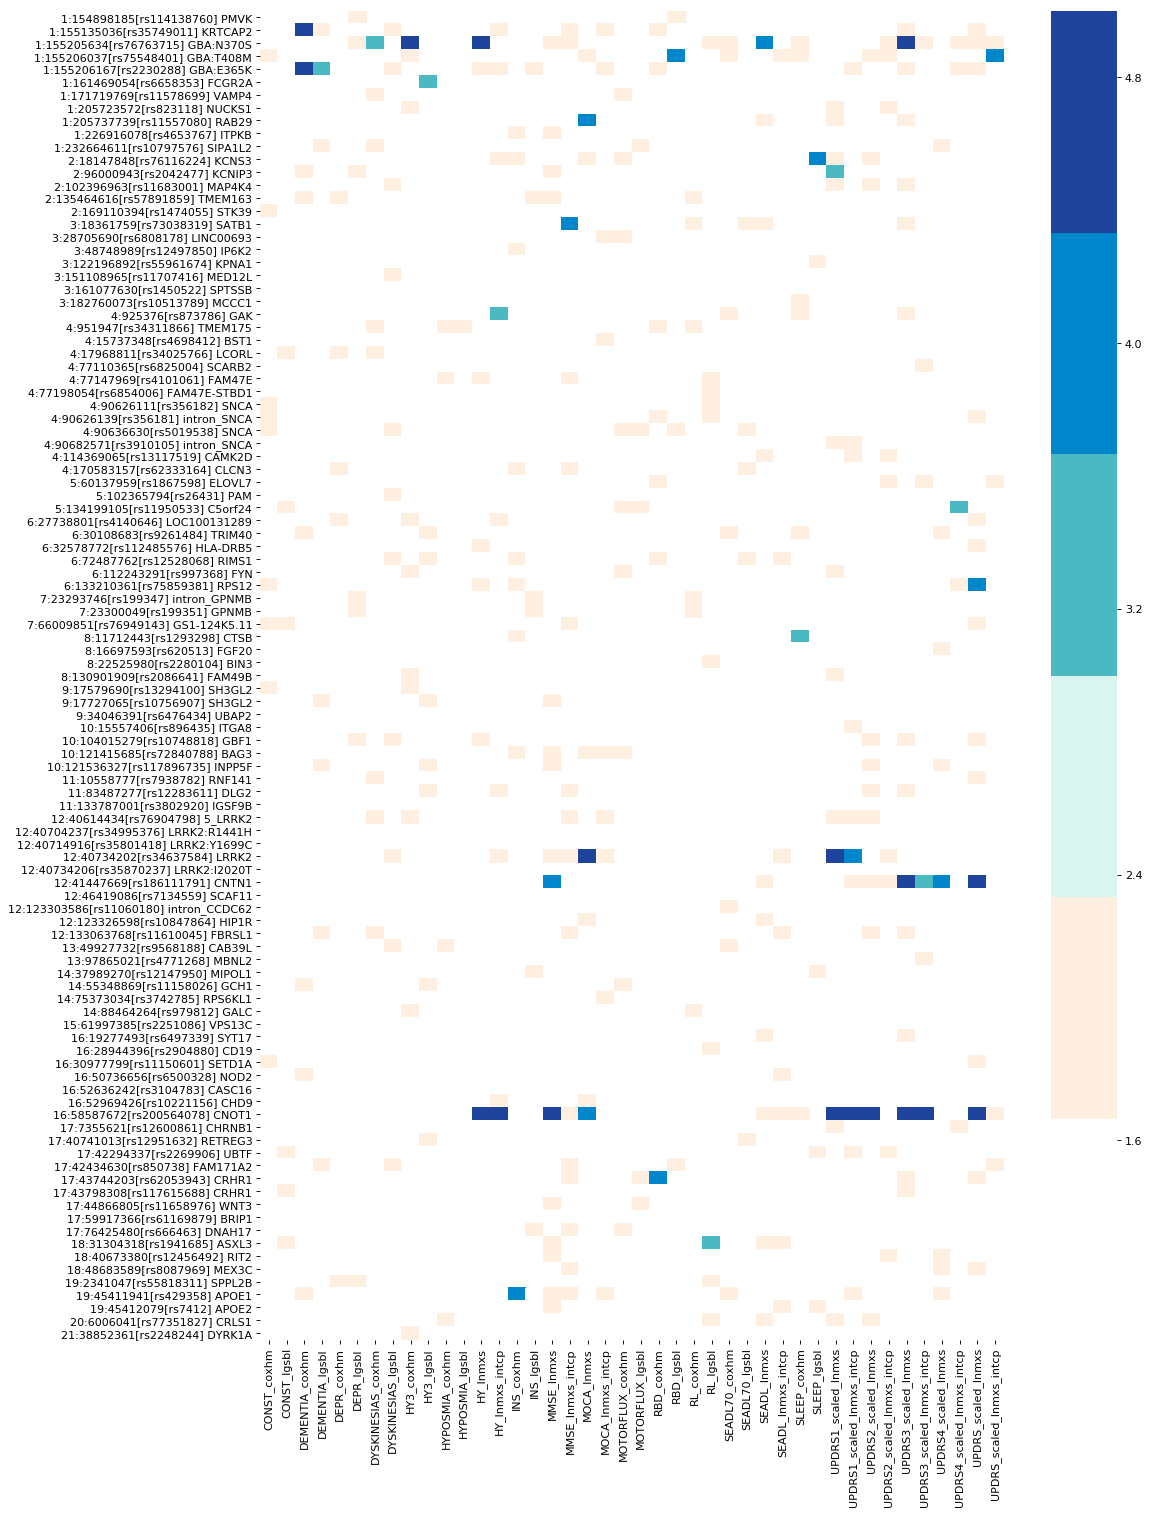

In [126]:
n = 40
def cut_func(x):
    if x <= -np.log10(0.05):
        return 1
    elif x <= -np.log10(0.05/n):
        return 2
    elif x <= -np.log10(0.05/92):
        return 3
    elif x <= -np.log10(0.05/92/n):
        return 4
    elif x > -np.log10(0.05/92/n):
        return 5
    else:
        return np.nan
dft = df_out.iloc[:, :].applymap(cut_func) # apply significance category
_cmap = ["#FFFFFF", "#ffefe1", "#daf4f0", "#4bb9c2", "#0086cb", "#1e439B"]
fig=plt.figure(figsize=(15, 22), dpi= 80, facecolor='w', edgecolor='k', )
sns.heatmap(dft, cmap=_cmap)
plt.savefig('fig/output.png', bbox_inches='tight', dpi=150)

In [145]:
df_out = df_out.append(df_out2)

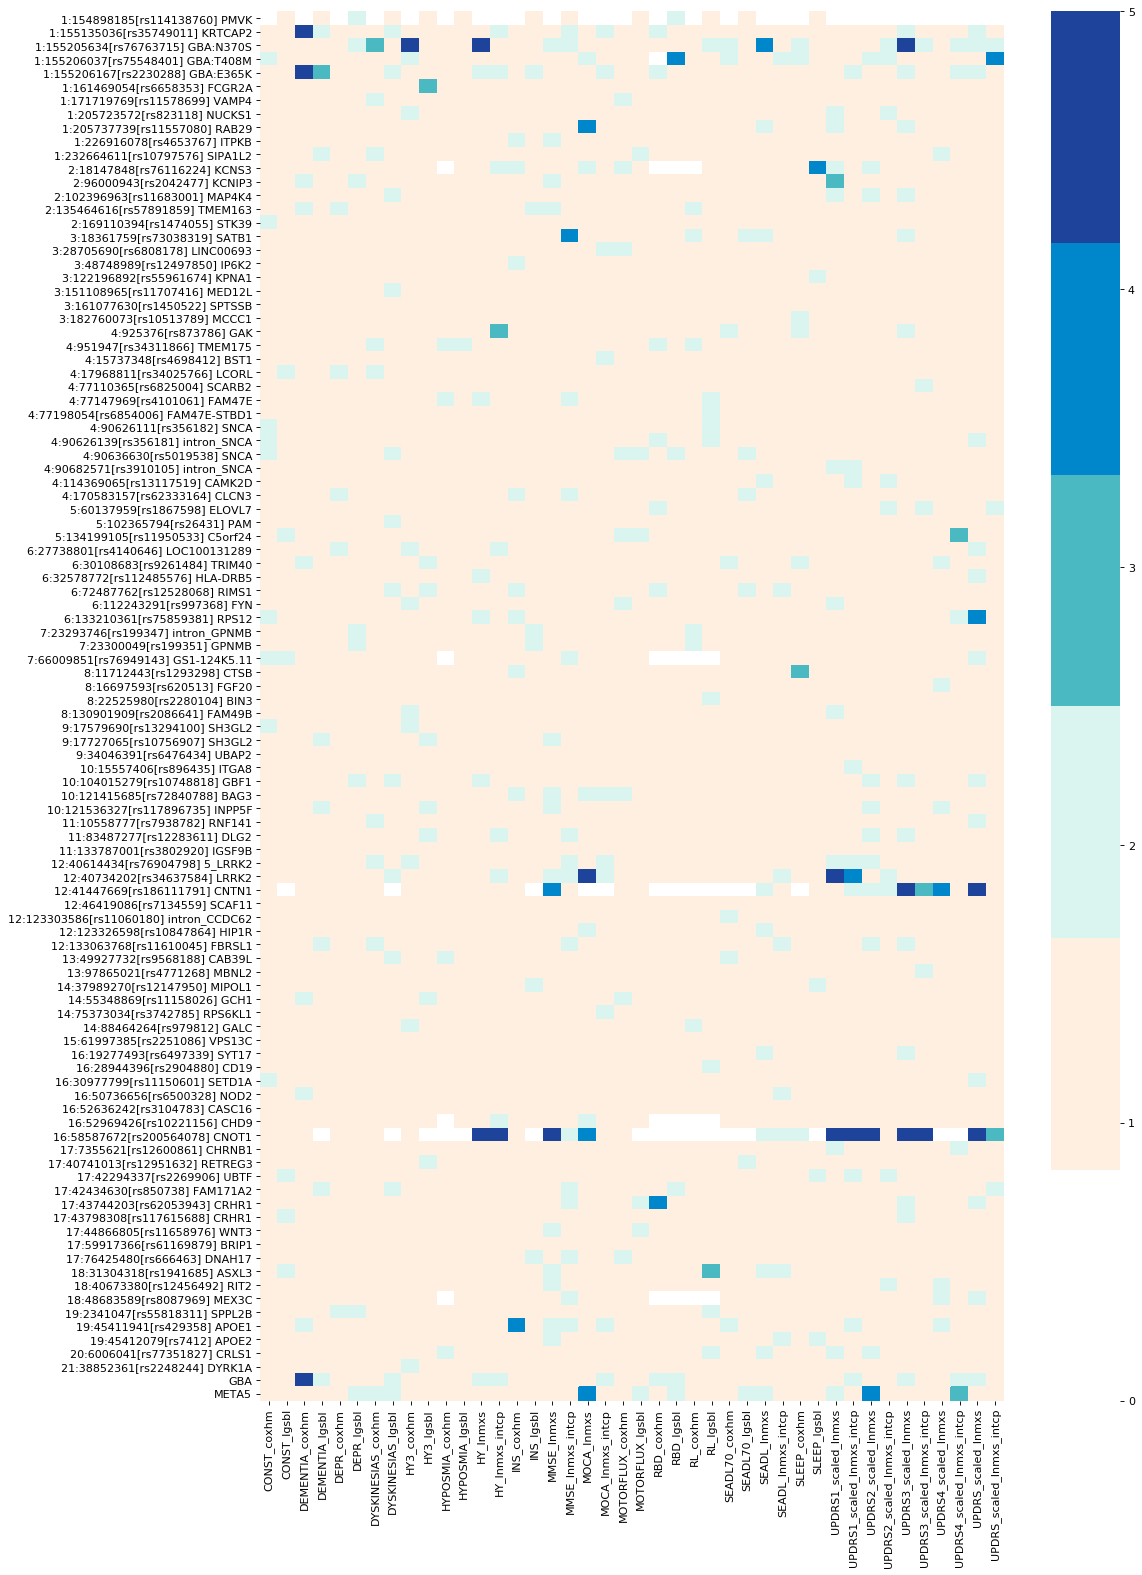

In [146]:
N_Variants=103.001 - df_out.isnull().sum(axis=0)
N_tests=42.001 - df_out.isnull().sum(axis=1)
t1=df_out.isnull() == False
t2=df_out > -np.log10(0.05)
t3=df_out.add(-np.log10(N_tests),axis=0) > -np.log10(0.05) 
t4=df_out.add(-np.log10(N_Variants),axis=1) > -np.log10(0.05) 
t5=df_out.add(-np.log10(N_tests),axis=0).add(-np.log10(N_Variants),axis=1) > -np.log10(0.05) 
dft=(t1*1).add(t2*1).add(t3*1).add(t4*1).add(t5*1)
dft_select = dft.loc[N_tests>0.1,:].astype('int')
_cmap = ["#FFFFFF", "#ffefe1", "#daf4f0", "#4bb9c2", "#0086cb", "#1e439B"]
fig=plt.figure(figsize=(15, 23), dpi= 80, facecolor='w', edgecolor='k', )
sns.heatmap(dft_select, cmap=_cmap)
plt.savefig('fig/output2.png', bbox_inches='tight', dpi=150)